In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

In [3]:
def convert_polygons_to_pixels(parcel_geometry, polygon_labels, size):
        # Create a black background
        background = np.zeros(size, dtype=np.uint8)
         
        # Get the polygon bounds
        min_lon, min_lat, max_lon, max_lat = parcel_geometry.bounds

        # Get the width and height of the parcel
        height = max_lat - min_lat
        width = max_lon - min_lon

        # Get the pixel width and height
        pixel_height = size[0]/height
        pixel_width = size[1]/width

        pixel_masks = []
        for label in polygon_labels.geometry:
            pixel_mask = background.copy()
            # Iterate over the polygons in the multipolygon
            for polygon in label.geoms:
                coords = polygon.exterior.coords.xy

                # Get the pixel coords
                pixel_coords = []
                for i in range(len(coords[0])):
                    x = coords[0][i]
                    y = coords[1][i]

                    # Get the pixel x and y
                    pixel_x = (x - min_lon) * pixel_width
                    pixel_y = (max_lat - y) * pixel_height

                    pixel_coords.append([pixel_x, pixel_y])

                # Convert to int to make it work with cv2
                pixel_coords = np.array(pixel_coords, dtype=np.int32)
                # Fill the polygons and append to the pixel mask
                cv2.fillPoly(pixel_mask, pts=[pixel_coords], color=255)
            pixel_masks.append(pixel_mask)
        
        # Return the pixel masks as a numpy array
        return pixel_masks

In [4]:
image_path = "/home/aghosh57/Kerner-Lab/SAM-FineTuning/0072.png"
mask_path = "/home/aghosh57/Kerner-Lab/SAM-FineTuning/0072.geojson"
parcel_data_path = "/home/aghosh57/Kerner-Lab/SAM-FineTuning/parcel_data.geojson"

In [5]:
image = np.array(cv2.imread(image_path))

In [6]:
parcel_data = gpd.read_file(parcel_data_path)
polygon_mask = gpd.read_file(mask_path)

for _, data in parcel_data.iterrows():
    parcel_id = data['parcel_id']
    geometry = data['geometry']

In [7]:
pixel_masks = convert_polygons_to_pixels(geometry, polygon_mask, (448, 448))

In [8]:
pixel_masks = np.array(pixel_masks)

In [9]:
pixel_masks_merged = np.logical_or.reduce(pixel_masks).astype(np.uint8)


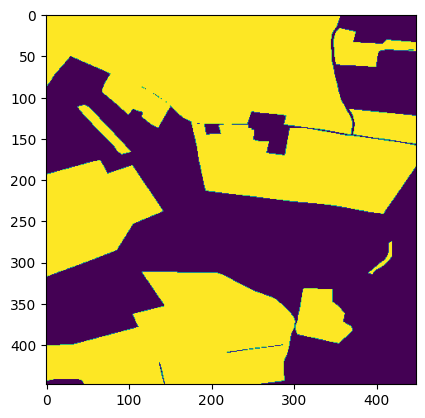

In [10]:
plt.imshow(pixel_masks_merged)

In [11]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(pixel_masks_merged, 4, cv2.CV_32S)

In [13]:
for i in range(0, nb_components):
    # skip first component as it is the background which we do not want to consider
    if i == 0:
        continue
    # extract the connected component statistics and centroid for the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]

    print("i : ", i)
    print("Area : ", area)
    print("Centroids : ", round(cX), round(cY))

i :  1
Area :  61104
Centroids :  236 103
i :  2
Area :  2330
Centroids :  384 42
i :  3
Area :  877
Centroids :  70 139
i :  4
Area :  2456
Centroids :  410 135
i :  5
Area :  12922
Centroids :  55 240
i :  6
Area :  214
Centroids :  409 297
i :  7
Area :  27802
Centroids :  170 392
i :  8
Area :  3168
Centroids :  333 366
